In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import random
import warnings
warnings.filterwarnings('ignore')

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device : {device}")
print(f"   GPU   : {torch.cuda.get_device_name(0)}")


✅ Device : cuda
   GPU   : NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [2]:
def generate_ndvi_series(n_samples=5000):
    """
    Realistic NDVI time-series generate karo
    
    Features per timestep (30 days):
    - NDVI value         (0.0 to 1.0)
    - Temperature        (15°C to 40°C normalized)
    - Humidity           (30% to 100% normalized)
    - Rainfall           (0 to 50mm normalized)
    - Day of year        (1-365 normalized)
    
    Target (7 days):
    - Risk score per day (0.0 = healthy, 1.0 = high risk)
    """
    
    SEQUENCE_LEN = 30   # 30 days input
    FORECAST_LEN = 7    # 7 days output
    
    X = []   # Input sequences
    y = []   # Target risk scores
    
    for _ in range(n_samples):
        # Season simulate karo
        start_day  = random.randint(1, 330)
        season_val = np.sin(2 * np.pi * start_day / 365)   # -1 to 1
        
        # Base NDVI (healthy = 0.6-0.8, stressed = 0.3-0.5)
        is_diseased   = random.random() < 0.35   # 35% disease cases
        base_ndvi     = random.uniform(0.3, 0.5) if is_diseased \
                        else random.uniform(0.55, 0.85)
        
        sequence = []
        for day in range(SEQUENCE_LEN):
            # NDVI trend
            if is_diseased:
                ndvi_trend = -0.008 * day   # Gradually declining
            else:
                ndvi_trend = random.uniform(-0.002, 0.003)
            
            ndvi  = np.clip(base_ndvi + ndvi_trend + random.gauss(0, 0.02), 0, 1)
            
            # Weather features (normalized 0-1)
            temp     = (random.uniform(20, 38) - 15) / 25
            humidity = random.uniform(0.4, 0.95)
            rainfall = random.uniform(0, 1) if random.random() < 0.3 else 0
            day_norm = (start_day + day) % 365 / 365
            
            # Disease favoring conditions
            disease_weather = (humidity > 0.75) and (0.4 < temp < 0.8)
            
            sequence.append([ndvi, temp, humidity, rainfall, day_norm])
        
        # Risk score generate karo (7 days ahead)
        risk_scores = []
        for future_day in range(FORECAST_LEN):
            if is_diseased:
                # Risk increases as disease progresses
                risk = min(0.95, 0.4 + 0.08 * future_day + random.gauss(0, 0.05))
            else:
                # Low risk but weather can push it up
                risk = max(0.02, 0.1 + (0.3 if disease_weather else 0) \
                           + random.gauss(0, 0.04))
            risk_scores.append(np.clip(risk, 0, 1))
        
        X.append(sequence)
        y.append(risk_scores)
    
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Generate karo
print("Generating synthetic NDVI time-series data...")
X, y = generate_ndvi_series(n_samples=8000)

print(f"✅ Dataset generated!")
print(f"   X shape : {X.shape}  → (samples, 30 days, 5 features)")
print(f"   y shape : {y.shape}  → (samples, 7 day risk scores)")
print(f"\n   Feature columns:")
print(f"   [0] NDVI value     (0-1)")
print(f"   [1] Temperature    (normalized)")
print(f"   [2] Humidity       (normalized)")
print(f"   [3] Rainfall       (normalized)")
print(f"   [4] Day of year    (normalized)")


Generating synthetic NDVI time-series data...
✅ Dataset generated!
   X shape : (8000, 30, 5)  → (samples, 30 days, 5 features)
   y shape : (8000, 7)  → (samples, 7 day risk scores)

   Feature columns:
   [0] NDVI value     (0-1)
   [1] Temperature    (normalized)
   [2] Humidity       (normalized)
   [3] Rainfall       (normalized)
   [4] Day of year    (normalized)


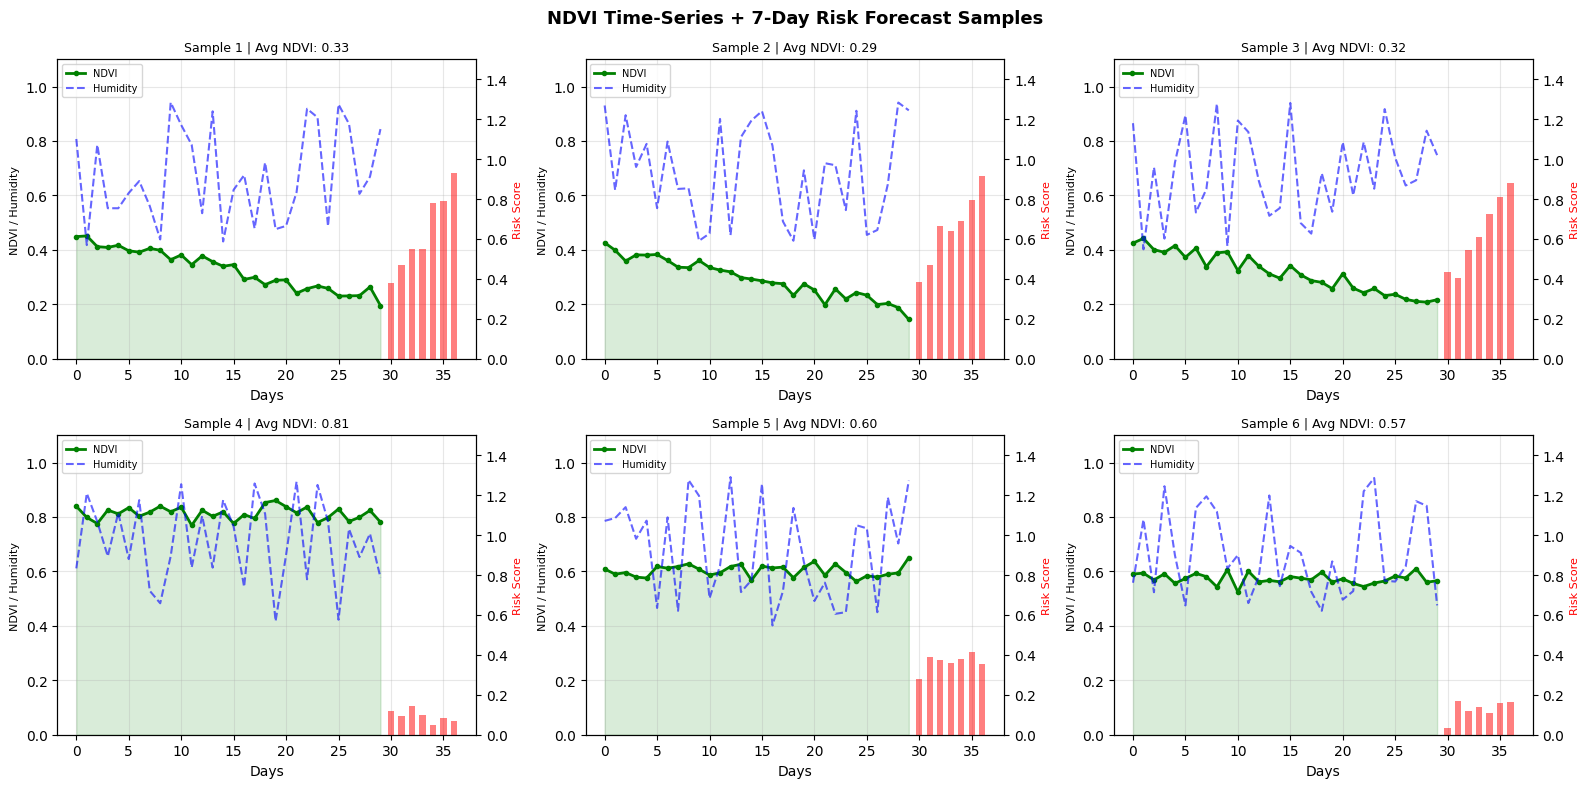

✅ NDVI sample visualization saved!


In [3]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

# 6 sample sequences plot karo
for i in range(6):
    ax  = axes[i]
    ax2 = ax.twinx()   # Second y-axis for risk

    days    = range(30)
    ndvi    = X[i, :, 0]
    risk    = y[i]
    humidity= X[i, :, 2]

    ax.plot(days, ndvi, 'g-o', markersize=3, label='NDVI', linewidth=2)
    ax.fill_between(days, ndvi, alpha=0.15, color='green')
    ax.plot(days, humidity, 'b--', markersize=2, label='Humidity', alpha=0.6)

    # 7-day forecast risk
    forecast_days = range(30, 37)
    ax2.bar(forecast_days, risk, color='red', alpha=0.5, width=0.6, label='Risk')
    ax2.set_ylim(0, 1.5)
    ax2.set_ylabel("Risk Score", color='red', fontsize=8)

    ax.set_title(f"Sample {i+1} | Avg NDVI: {ndvi.mean():.2f}", fontsize=9)
    ax.set_xlabel("Days")
    ax.set_ylabel("NDVI / Humidity", fontsize=8)
    ax.set_ylim(0, 1.1)
    ax.legend(loc='upper left', fontsize=7)
    ax.grid(True, alpha=0.3)

plt.suptitle(
    "NDVI Time-Series + 7-Day Risk Forecast Samples",
    fontsize=13, fontweight='bold'
)
plt.tight_layout()
plt.savefig("ndvi_samples.png", dpi=150)
plt.show()
print("✅ NDVI sample visualization saved!")


In [4]:
from sklearn.model_selection import train_test_split

class NDVIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(NDVIDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(NDVIDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(NDVIDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

print(f"✅ Datasets ready!")
print(f"   Train : {len(X_train):,} samples")
print(f"   Val   : {len(X_val):,} samples")
print(f"   Test  : {len(X_test):,} samples")


✅ Datasets ready!
   Train : 6,400 samples
   Val   : 800 samples
   Test  : 800 samples


In [5]:
class CropRiskLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=128,
                 num_layers=2, forecast_days=7, dropout=0.3):
        super(CropRiskLSTM, self).__init__()
        
        self.hidden_size  = hidden_size
        self.num_layers   = num_layers
        self.forecast_days= forecast_days
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size  = input_size,
            hidden_size = hidden_size,
            num_layers  = num_layers,
            batch_first = True,
            dropout     = dropout,
            bidirectional = True    # Forward + backward context
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        
        # Forecast head
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, forecast_days),
            nn.Sigmoid()   # Risk score 0-1
        )
    
    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        # lstm_out: (batch, seq_len, hidden*2)
        
        # Attention weights
        attn_weights = self.attention(lstm_out)
        # Weighted sum
        context = (attn_weights * lstm_out).sum(dim=1)
        
        # Forecast
        output = self.fc(context)
        return output

# Model banao
lstm_model = CropRiskLSTM(
    input_size    = 5,    # NDVI + temp + humidity + rainfall + day
    hidden_size   = 128,
    num_layers    = 2,
    forecast_days = 7,
    dropout       = 0.3
).to(device)

total_params = sum(p.numel() for p in lstm_model.parameters())
print(f"✅ LSTM Model ready!")
print(f"   Architecture   : Bidirectional LSTM + Attention")
print(f"   Input          : 30 days × 5 features")
print(f"   Hidden size    : 128 (bidirectional = 256)")
print(f"   Layers         : 2")
print(f"   Output         : 7 day risk scores")
print(f"   Total params   : {total_params:,}")


✅ LSTM Model ready!
   Architecture   : Bidirectional LSTM + Attention
   Input          : 30 days × 5 features
   Hidden size    : 128 (bidirectional = 256)
   Layers         : 2
   Output         : 7 day risk scores
   Total params   : 591,624


In [6]:
LSTM_EPOCHS = 60
criterion_lstm = nn.MSELoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_lstm = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_lstm, T_max=LSTM_EPOCHS, eta_min=1e-5
)

history_lstm = {"train_loss": [], "val_loss": []}
best_val_loss = float('inf')

print("🔥 LSTM Training Started...")
print("=" * 55)

for epoch in range(LSTM_EPOCHS):
    # Train
    lstm_model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_lstm.zero_grad()
        preds = lstm_model(X_batch)
        loss  = criterion_lstm(preds, y_batch)
        loss.backward()
        nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        optimizer_lstm.step()
        train_loss += loss.item()
    
    # Validate
    lstm_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds    = lstm_model(X_batch)
            val_loss += criterion_lstm(preds, y_batch).item()
    
    t_loss = train_loss / len(train_loader)
    v_loss = val_loss   / len(val_loader)
    
    history_lstm["train_loss"].append(t_loss)
    history_lstm["val_loss"].append(v_loss)
    scheduler_lstm.step()
    
    # Best model save
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        torch.save(lstm_model.state_dict(), Path("../models/lstm_model.pth"))
        saved = "✅ SAVED"
    else:
        saved = ""
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3}/{LSTM_EPOCHS} | "
              f"Train: {t_loss:.5f} | Val: {v_loss:.5f} {saved}")

print(f"\n🏆 Best Val Loss : {best_val_loss:.5f}")
print(f"✅ lstm_model.pth saved!")
torch.cuda.empty_cache()


🔥 LSTM Training Started...
Epoch  10/60 | Train: 0.01219 | Val: 0.01269 
Epoch  20/60 | Train: 0.01201 | Val: 0.01155 
Epoch  30/60 | Train: 0.01162 | Val: 0.01119 ✅ SAVED
Epoch  40/60 | Train: 0.00892 | Val: 0.00827 ✅ SAVED
Epoch  50/60 | Train: 0.00827 | Val: 0.00812 
Epoch  60/60 | Train: 0.00815 | Val: 0.00777 ✅ SAVED

🏆 Best Val Loss : 0.00777
✅ lstm_model.pth saved!


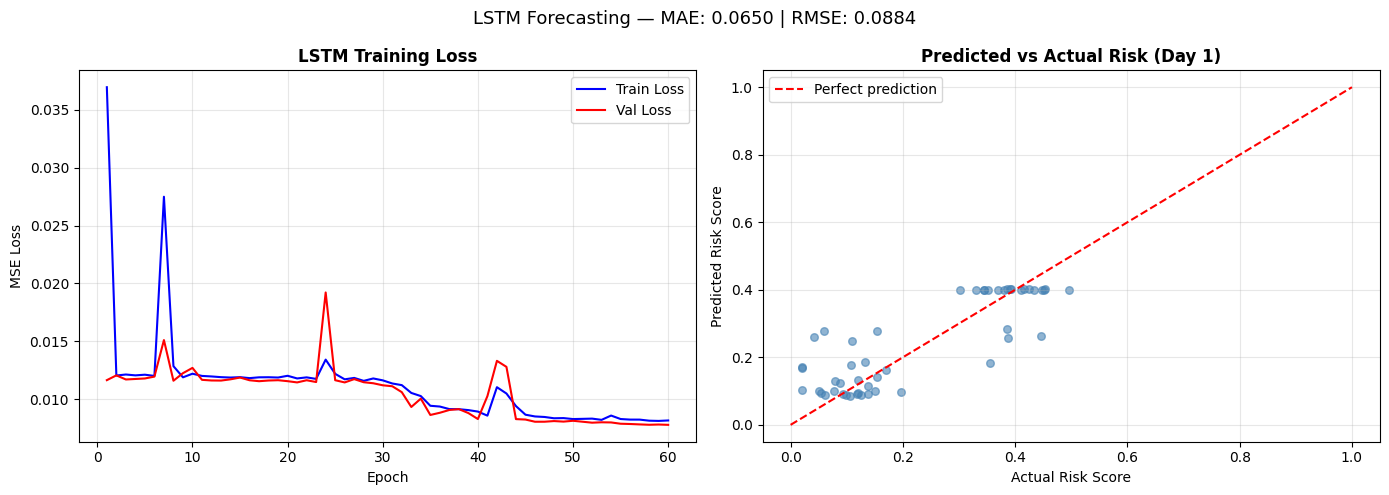

✅ LSTM Evaluation:
   MAE  : 0.0650  (lower = better, < 0.1 is good)
   RMSE : 0.0884 (lower = better, < 0.15 is good)


In [7]:
# Test set evaluation
lstm_model.load_state_dict(
    torch.load(Path("../models/lstm_model.pth"), map_location=device)
)
lstm_model.eval()

all_preds, all_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = lstm_model(X_batch.to(device))
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_true  = np.array(all_true)

# MAE + RMSE
mae  = np.mean(np.abs(all_preds - all_true))
rmse = np.sqrt(np.mean((all_preds - all_true) ** 2))

# Training loss graph
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_r = range(1, LSTM_EPOCHS + 1)
axes[0].plot(epochs_r, history_lstm["train_loss"], 'b-', label='Train Loss')
axes[0].plot(epochs_r, history_lstm["val_loss"],   'r-', label='Val Loss')
axes[0].set_title("LSTM Training Loss", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Prediction vs actual (first 10 test samples, day 1)
sample_true = all_true[:50, 0]
sample_pred = all_preds[:50, 0]
axes[1].scatter(sample_true, sample_pred, alpha=0.6, color='steelblue', s=30)
axes[1].plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
axes[1].set_title("Predicted vs Actual Risk (Day 1)", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Actual Risk Score")
axes[1].set_ylabel("Predicted Risk Score")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle(f"LSTM Forecasting — MAE: {mae:.4f} | RMSE: {rmse:.4f}", fontsize=13)
plt.tight_layout()
plt.savefig("lstm_evaluation.png", dpi=150)
plt.show()

print(f"✅ LSTM Evaluation:")
print(f"   MAE  : {mae:.4f}  (lower = better, < 0.1 is good)")
print(f"   RMSE : {rmse:.4f} (lower = better, < 0.15 is good)")


In [8]:
lstm_config = {
    "input_size"    : 5,
    "hidden_size"   : 128,
    "num_layers"    : 2,
    "forecast_days" : 7,
    "dropout"       : 0.3,
    "sequence_len"  : 30,
    "features"      : ["ndvi", "temperature", "humidity", "rainfall", "day_of_year"],
    "mae"           : round(float(mae), 4),
    "rmse"          : round(float(rmse), 4),
    "best_val_loss" : round(float(best_val_loss), 5)
}

with open(Path("../models/lstm_config.json"), "w") as f:
    json.dump(lstm_config, f, indent=2)

print("✅ LSTM config saved!")
print(f"\n   📁 models/")
print(f"      lstm_model.pth      ← Trained LSTM weights")
print(f"      lstm_config.json    ← Model config + metrics")
print(f"\n   Next → Day 7: FastAPI ML Service")


✅ LSTM config saved!

   📁 models/
      lstm_model.pth      ← Trained LSTM weights
      lstm_config.json    ← Model config + metrics

   Next → Day 7: FastAPI ML Service
